# Cleaning and EDA: Pew Data

In this notebook, I cleaned and formatted the Pew dataset so it was ready for modeling. I also did some light EDA to see how the features interacted with the target variable. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pew = pd.read_csv('../data/pew.txt')
print(pew.shape)
pew.head()

(4708, 159)


,QKEY,INTERVIEW_START_W69,INTERVIEW_END_W69,DEVICE_TYPE_W69,LANG_W69,FORM_W69,SATIS_W69,POL1DT_W69,POL1DTSTR_W69,FUTGEN_W69,...,POL1DTSTR_W64,DEMFIELD_W59,TRUMPDEM2020_W59,DEM1_CODE_FINAL_W59,COVID_DEATHS_CNTY_W69,BATTLE_NARROW_W69,WEIGHT_W69_CENSUS,WEIGHT_W59_W69,WEIGHT_W64_W69,WEIGHT_W69
0,100260,2020-6-17 16:20:46.000,2020-6-17 16:36:5.000,3,1,2,2,1,1,1,...,1,,1,,2,1,0.725967,0.6272713320551427,0.617936009359436,0.731921
1,100637,2020-6-18 14:48:14.000,2020-6-18 15:3:26.000,1,1,2,2,1,1,1,...,1,,1,,2,3,1.349430,0.6754638453876008,0.707802384563748,0.762127
2,101472,2020-6-19 10:45:50.000,2020-6-19 10:55:23.000,2,1,1,2,2,1,3,...,1,,5,,2,4,1.746954,1.6850284516246583,1.7612633160818703,2.052434
3,101493,2020-6-17 10:48:28.000,2020-6-17 12:33:47.000,2,1,2,2,1,1,2,...,1,,1,,1,1,0.800370,0.8668663802477705,0.9633645897670713,0.932218
4,103094,2020-6-17 18:27:16.000,2020-6-19 14:14:5.000,2,1,1,2,99,,3,...,1,3,,99,2,3,2.439017,3.163657274096003,2.894057482548047,3.146019


Here, I selected all of the columns starting with `F_` because, according to the [data dictionary](https://www.pewresearch.org/wp-content/uploads/2018/05/Codebook-and-instructions-for-working-with-ATP-data.pdf), these are the demographic columns and therefore the columns I will focus on for my project.

In [3]:
demo_cols = pew.loc[:,pew.columns.str.startswith('F_')].columns
demo_cols = [col for col in demo_cols if col not in ['F_EDUCCAT', 'F_RACETHNMOD', 'F_BORN', 'F_INCOME_RECODE',
                'F_VOLSUM','F_HISP_ORIGIN','F_PARTYLN_FINAL']]
df = pew.loc[:, demo_cols]
print(df.shape)
df.head()

(4708, 22)


,F_METRO,F_CREGION,F_CDIVISION,F_AGECAT,F_SEX,F_EDUCCAT2,F_HISP,F_RACECMB,F_CITIZEN,F_NATIVITY2,...,F_ATTEND,F_PARTY_FINAL,F_PARTYSUM_FINAL,F_INCOME,F_REG,F_IDEO,F_ACSWEB,F_INC_TIER2,F_YEARSINUS,F_PARTYSUMIDEO
0,1,4,9,4,1,5,2,1,1,1,...,5,1,1,6,1,1,1,2,1,1
1,1,3,5,3,2,4,2,1,1,1,...,3,3,1,4,1,2,1,2,1,1
2,1,3,7,2,1,6,2,1,1,1,...,5,3,1,7,3,3,2,3,1,2
3,1,4,9,3,1,3,1,1,1,1,...,6,1,1,6,1,2,1,2,1,1
4,1,1,2,2,2,2,99,99,99,1,...,99,4,2,2,,99,1,99,1,9


## Mapping and renaming

Now that I have those selected, I'm going to go through and map all of the values in those columns to either my preferred numerical order (i.e. 0 and 1 instead of 1 and 2) or to the strings corresponding with each value so that I can dummy these columns later and maintain some interpretability. In a few cases, I mapped certain values to `'111_other'` or `'111_refused'` so that those would be the columns dropped in the dummying process. I also added a few comments to explain what the values mean but please check out the README for more easily interpretable explanations.

In [4]:
# mapping dicts

rebinarize_dict = {1: 1, 2: 0}

f_cregion = {1: 'northeast',2: 'midwest', 3: 'south', 4: 'west'}
f_cdivision = {1: 'new_england', 2: 'mid_atlantic', 3: 'east_north_central', 4: 'west_north_central',
             5: 'south_atlantic', 6: 'east_south_central', 7: 'west_south_central', 8: 'mountain', 9: 'pacific'}
f_agecat = {1: 1., 2: 2., 3: 3., 4: 4., 99: np.nan} # 1 = 18-29, 2 = 30-49, 3 = 50-64, 4 = 65+
f_sex = {1: 0, 2: 1, 99: np.nan}
f_educcat2 = {i: i for i in range(1,15)} # 1 = less than highschool, 14 = doctorate
f_educcat2[99] = np.nan
f_hisp = {1: 1, 2: 0, 99: np.nan}
f_racecmb = {1: 'white', 2: 'black', 3: 'asian', 4: 'mixed', 5: 'other', 99: '111_refused'}
f_nativity2 = {1: 'usa', 2: 'puerto_rico', 3: 'us_territory', 4: 'cuba', 5: 'mexico', 99: '111_refused'}
f_marital = {1: 'married', 2: 'live_w_partner', 3: 'divorced', 4: 'separated', 5: 'widowed', 6: 'single'}
f_relig = {1:'protestant',2:'catholic',3:'mormon',4:'orthodox',5:'jewish',6:'muslim',7:'buddhist',8:'hindu', 
           9: 'atheist', 10: 'agnostic', 11: 'other', 12: 'none', 13: 'christian', 14: 'unitarian', 99: '111_refused'}
f_attend = {i: i for i in range(1,7)} # 1 = more than once a week, 6 = never
f_attend[99] = np.nan
f_party_final = {1: 'gop', 2: 'dem', 3: 'ind', 4: '111_other'}
f_partysum_final = {1: 'gop', 2: 'dem', 3: 'ind', 99: '111_refused'}
f_income = {i: i for i in range(1,10)} # 1 = less than $10k, 9 $150k or more 
f_income[99] = np.nan
f_reg = {'1':'registered', '2': 'prob_registered', '3': 'not_registered', '99': '111_refused', ' ': '111_refused'}
f_ideo = {i: i for i in range(1,6)} # 1 = very conservative, 5 = very liberal
f_ideo[99] = np.nan
f_inc_tier2 = {i: i for i in range(1,4)} # 1 = lower class, 3 = upper class
f_inc_tier2[99] = np.nan
f_yearsinus = {1: 4, 2: 1, 3: 2, 4: 3, 99: np.nan} # 1 = 0-10 years, 4 = born in us
f_partysumideo = {i: i  for i in range(1,5)} 
f_partysumideo[99] = np.nan # 1 = conservative gop, 2 = moderate gop, 3 = moderate dem, 4 = liberal dem

In [5]:
# applying maps and renaming columns for interpretability

col_dicts = [rebinarize_dict, f_cregion, f_cdivision, f_agecat, f_sex, f_educcat2, f_hisp, f_racecmb, rebinarize_dict,
             f_nativity2, f_marital, f_relig, f_attend, f_party_final, f_partysum_final,
             f_income, f_reg, f_ideo, rebinarize_dict, f_inc_tier2, f_yearsinus, f_partysumideo]
             

new_col_names = ['lives_in_metro_area', 'large_region', 'region', 'age_group', 'is_female', 'education_level',
                'is_hispanic', 'race', 'is_citizen', 'national_origin', 'marital_status', 'religion',
                 'relig_activity','political_party', 'final_party', 'income_bracket', 'voter_status',
                 'ideology','internet_access', 'class', 'years_in_usa', 'party_and_ideo']

try:
    df.drop(columns = cols_to_drop, inplace=True)
except:
    pass

for c, d in zip(df.columns, col_dicts):
    df[c] = df[c].map(d)
    
df.columns = new_col_names
df.head() # mapped and renamed columns


,lives_in_metro_area,large_region,region,age_group,is_female,education_level,is_hispanic,race,is_citizen,national_origin,...,relig_activity,political_party,final_party,income_bracket,voter_status,ideology,internet_access,class,years_in_usa,party_and_ideo
0,1,west,pacific,4.0,0.0,5.0,0.0,white,1.0,usa,...,5.0,gop,gop,6.0,registered,1.0,1,2.0,4.0,1.0
1,1,south,south_atlantic,3.0,1.0,4.0,0.0,white,1.0,usa,...,3.0,ind,gop,4.0,registered,2.0,1,2.0,4.0,1.0
2,1,south,west_south_central,2.0,0.0,6.0,0.0,white,1.0,usa,...,5.0,ind,gop,7.0,not_registered,3.0,0,3.0,4.0,2.0
3,1,west,pacific,3.0,0.0,3.0,1.0,white,1.0,usa,...,6.0,gop,gop,6.0,registered,2.0,1,2.0,4.0,1.0
4,1,northeast,mid_atlantic,2.0,1.0,2.0,NaN,111_refused,NaN,usa,...,NaN,111_other,dem,2.0,111_refused,NaN,1,NaN,4.0,NaN


Out of curiosity, I'm going to add in some other columns, but I will likely drop many of them since they have a lot of null values.

In [6]:
# adding some other columns

other_cols = ['POLICE_FUND_W69','POLICEQ_IMMUNITY_W69','SATIS_W69','FUTGEN_W69',
              'FEEL_COUNTRY_ANGRY_W69','FEEL_COUNTRY_FEAR_W69','FEEL_COUNTRY_HOPEFUL_W69',
              'FEEL_COUNTRY_PROUD_W69','ECON1_W69', 'ECON1B_W69',
              'PRESGOODBIDEN_W69', 'C_MASKREACT_W69','C_SHOULDMASK_W69','GOVNEEDY_W69',
              'EXCPWER_W69','SNSUSE_W69']
                    
police_fund = {i: i  for i in range(1,6)} # budget should be 1 = increased a lot, 5 = decreased a lot
police_fund[99] = np.nan  
police_immunity = {1: 0, 2: 1} # police should be held accountable
futgen = {1: 'better_off', 2: 'worse_off', 3: 'status_quo'}
econ1 = {i: i  for i in range(1,5)} # 1 = excellent economy today, 4 = poor
econ1[99] = np.nan  
econ1b = {1: 'get_better', 2: 'get_worse', 3: 'stay_same'}
presgoodbiden = {i: i  for i in range(1,6)} # 1 = he'd be great president, 5 = terrible president
presgoodbiden[99] = np.nan 
c_maskreact = {1: 'approve', 2: 'disapprove', 3: 'not_care'}
c_shouldmask = {i: i  for i in range(1,6)} # 1 = always, 5 = never
c_shouldmask[99] = np.nan 

In [7]:
# applying maps and renaming columns for interpretability

col_dicts = [police_fund, police_immunity, rebinarize_dict, futgen, rebinarize_dict,
             rebinarize_dict, rebinarize_dict, rebinarize_dict, econ1,
             econ1b, presgoodbiden, c_maskreact, c_shouldmask,rebinarize_dict, rebinarize_dict, rebinarize_dict]

new_col_names = ['defund_support', 'police_accountability_support', 'general_satisfaction',
                 'future_generations', 'angry_abt_country','fear_abt_country',
                 'hopeful_abt_country','proud_abt_country','economy_status',
                 'economy_in_a_year', 'biden_good_pres', 'others_reaction_to_mask',
                 'should_wear_mask', 'welfare_support','executive_power', 'social_media_user']

for c, d, n in zip(other_cols, col_dicts, new_col_names):
    df[n] = pew[c].map(d)
        
df.iloc[:,20:].head()
        

,years_in_usa,party_and_ideo,defund_support,police_accountability_support,general_satisfaction,future_generations,angry_abt_country,fear_abt_country,hopeful_abt_country,proud_abt_country,economy_status,economy_in_a_year,biden_good_pres,others_reaction_to_mask,should_wear_mask,welfare_support,executive_power,social_media_user
0,4.0,1.0,3.0,0.0,0.0,better_off,1.0,0.0,1.0,1.0,2.0,get_better,5.0,approve,4.0,0.0,0.0,0.0
1,4.0,1.0,1.0,0.0,0.0,better_off,0.0,1.0,1.0,0.0,2.0,get_better,5.0,not_care,4.0,1.0,1.0,1.0
2,4.0,2.0,2.0,1.0,0.0,status_quo,0.0,0.0,1.0,1.0,2.0,stay_same,3.0,approve,2.0,1.0,0.0,1.0
3,4.0,1.0,5.0,0.0,0.0,worse_off,1.0,1.0,0.0,1.0,1.0,get_better,5.0,approve,1.0,0.0,NaN,1.0
4,4.0,NaN,4.0,1.0,0.0,status_quo,1.0,1.0,1.0,0.0,4.0,get_worse,3.0,not_care,1.0,1.0,0.0,0.0


## Accounting for null values

Now I'm going to drop columns with a significant number of null values so that there aren't as many rows with null values that I'll have to drop.

In [8]:
cols_w_nulls = list(df.loc[:,df.isnull().sum() > 20].columns)

cols_w_nulls

['age_group',
 'national_origin',
 'political_party',
 'final_party',
 'income_bracket',
 'ideology',
 'class',
 'years_in_usa',
 'party_and_ideo',
 'defund_support',
 'police_accountability_support',
 'general_satisfaction',
 'future_generations',
 'angry_abt_country',
 'fear_abt_country',
 'proud_abt_country',
 'economy_status',
 'economy_in_a_year',
 'biden_good_pres',
 'welfare_support',
 'executive_power']

There are a few columns I'd like to keep even though they have nulls (i.e. my target variable) so I remove those from the `cols_w_nulls` list before dropping all of those from the dataframe.

In [9]:
cols_to_keep = ['defund_support',  # target variable
                'income_bracket',  # i want to keep something related to class / wealth
                'political_party', # i also want to keep a party/ideology column
                'age_group'        # i suspect generation will be helpful and this is all i have for it
               ]

for col in cols_to_keep:
    try:
        cols_w_nulls.remove(col)
    except:
        pass
    
cols_w_nulls.append('large_region')    # having both region columns seems redundant

# these are the columns i'll have left over
[col for col in df.columns if col not in cols_w_nulls] # looks pretty good!

['lives_in_metro_area',
 'region',
 'age_group',
 'is_female',
 'education_level',
 'is_hispanic',
 'race',
 'is_citizen',
 'marital_status',
 'religion',
 'relig_activity',
 'political_party',
 'income_bracket',
 'voter_status',
 'internet_access',
 'defund_support',
 'hopeful_abt_country',
 'others_reaction_to_mask',
 'should_wear_mask',
 'social_media_user']

In [10]:
# dropping those columns with a lot of nulls and then dropping any rows with nulls still remaining

df.drop(columns = cols_w_nulls, inplace=True)
df.dropna(inplace=True)
print(df.shape)
df.head()

(4314, 20)


,lives_in_metro_area,region,age_group,is_female,education_level,is_hispanic,race,is_citizen,marital_status,religion,relig_activity,political_party,income_bracket,voter_status,internet_access,defund_support,hopeful_abt_country,others_reaction_to_mask,should_wear_mask,social_media_user
0,1,pacific,4.0,0.0,5.0,0.0,white,1.0,single,none,5.0,gop,6.0,registered,1,3.0,1.0,approve,4.0,0.0
1,1,south_atlantic,3.0,1.0,4.0,0.0,white,1.0,married,protestant,3.0,ind,4.0,registered,1,1.0,1.0,not_care,4.0,1.0
2,1,west_south_central,2.0,0.0,6.0,0.0,white,1.0,married,catholic,5.0,ind,7.0,not_registered,0,2.0,1.0,approve,2.0,1.0
3,1,pacific,3.0,0.0,3.0,1.0,white,1.0,married,agnostic,6.0,gop,6.0,registered,1,5.0,0.0,approve,1.0,1.0
5,1,mountain,3.0,0.0,5.0,0.0,white,1.0,married,catholic,5.0,ind,9.0,registered,1,3.0,0.0,approve,1.0,0.0


# Final column selection and export

Just to make sure I'm getting everything I want and nothing that I don't, I made a list of the columns I want to pass on to the modeling stage below and exported them to a CSV.

In [11]:
# dummying categorical columns
df = pd.get_dummies(df, columns = df.loc[:,df.dtypes == 'object'].columns, drop_first = True)
df.head()

,lives_in_metro_area,age_group,is_female,education_level,is_hispanic,is_citizen,relig_activity,income_bracket,internet_access,defund_support,...,religion_other,religion_protestant,political_party_dem,political_party_gop,political_party_ind,voter_status_not_registered,voter_status_prob_registered,voter_status_registered,others_reaction_to_mask_disapprove,others_reaction_to_mask_not_care
0,1,4.0,0.0,5.0,0.0,1.0,5.0,6.0,1,3.0,...,0,0,0,1,0,0,0,1,0,0
1,1,3.0,1.0,4.0,0.0,1.0,3.0,4.0,1,1.0,...,0,1,0,0,1,0,0,1,0,1
2,1,2.0,0.0,6.0,0.0,1.0,5.0,7.0,0,2.0,...,0,0,0,0,1,1,0,0,0,0
3,1,3.0,0.0,3.0,1.0,1.0,6.0,6.0,1,5.0,...,0,0,0,1,0,0,0,1,0,0
5,1,3.0,0.0,5.0,0.0,1.0,5.0,9.0,1,3.0,...,0,0,0,0,1,0,0,1,0,0


In [12]:
# just confirming which columns i want to move forward with
final_cols = ['defund_support','lives_in_metro_area', 'is_female', 'education_level', 'is_hispanic',
              'is_citizen','relig_activity','income_bracket', 'internet_access', 'social_media_user',
              'region_east_south_central','region_mid_atlantic', 'region_mountain',
              'region_new_england', 'region_pacific','region_south_atlantic',
              'region_west_north_central','region_west_south_central', 'age_group', 'race_asian', 'race_black','race_mixed',
              'race_other', 'race_white','marital_status_live_w_partner', 'marital_status_married',
              'marital_status_separated', 'marital_status_single','marital_status_widowed', 'religion_agnostic',
              'religion_atheist','religion_buddhist', 'religion_catholic', 'religion_hindu','religion_jewish',
              'religion_mormon', 'religion_muslim','religion_none', 'religion_orthodox', 'religion_other',
              'religion_protestant','political_party_dem', 'political_party_gop', 'political_party_ind',
              'voter_status_not_registered','voter_status_prob_registered', 'voter_status_registered']

# exporting to csv for use in the modeling notebook
df = df.loc[:,final_cols]
df.to_csv('../data/pew_cleaned.csv', index = False)

# EDA

## Charting relationships

I'm not sure what to expect as far as relationships with the target variable, so I'm going to create a loop to chart a ton of the relationships in one go. They won't be super interpretable without tick labels, but they'll help me get a sense of which features and specific values have relationships with support for defunding the police.

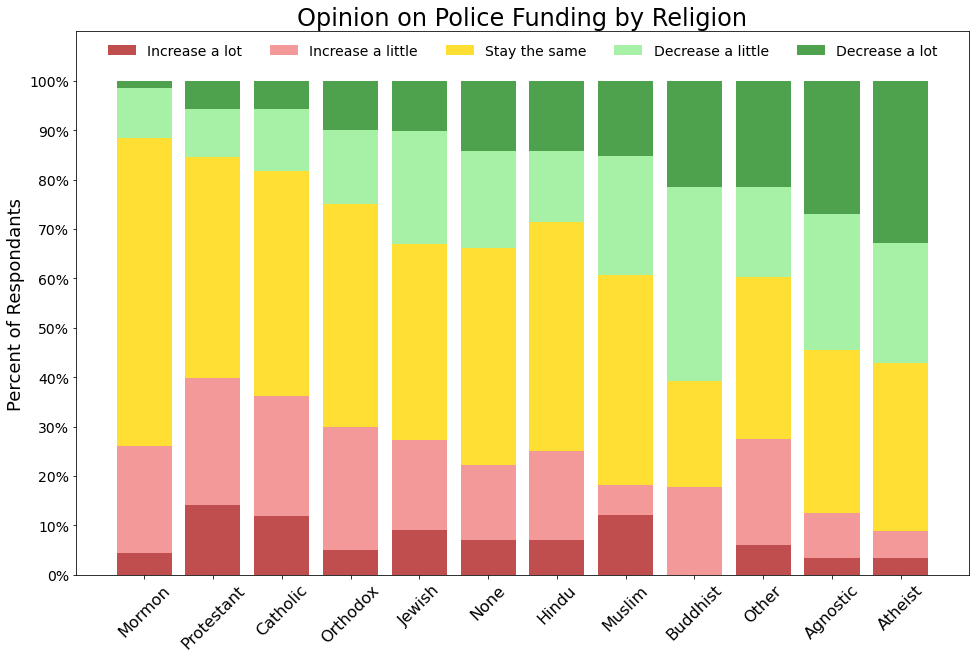

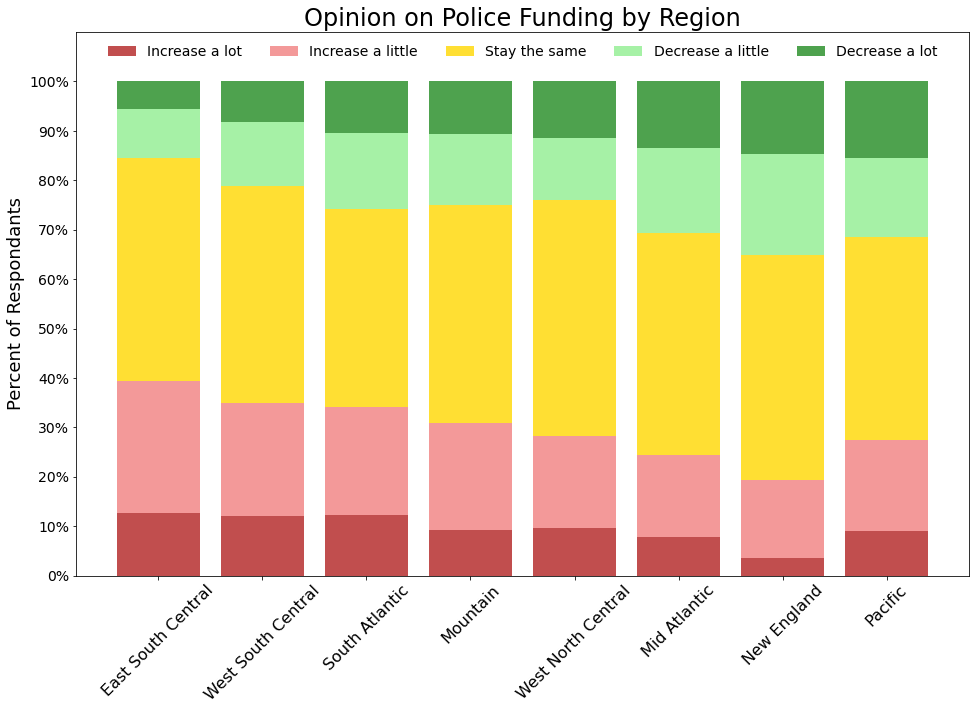

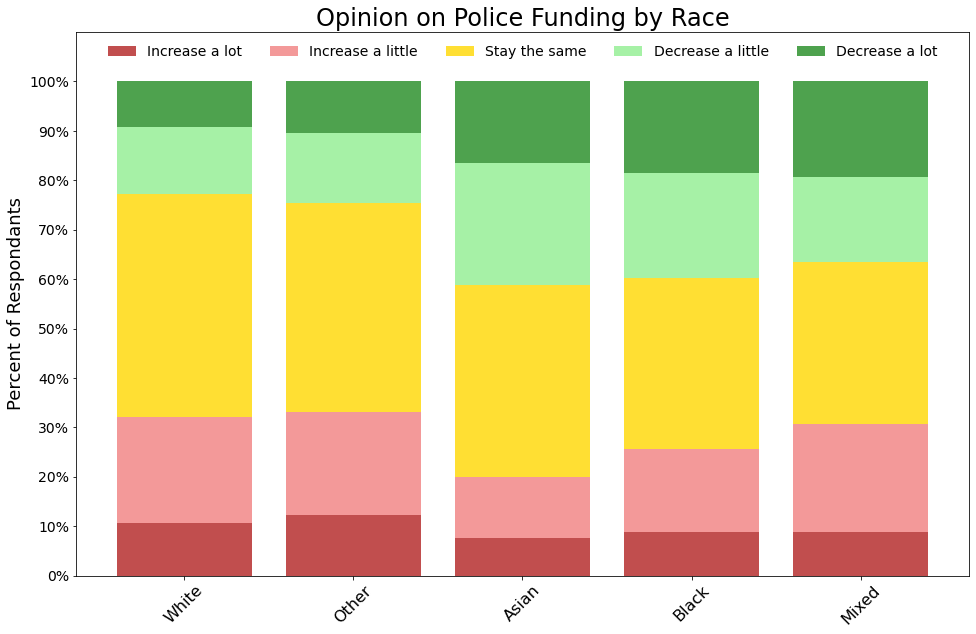

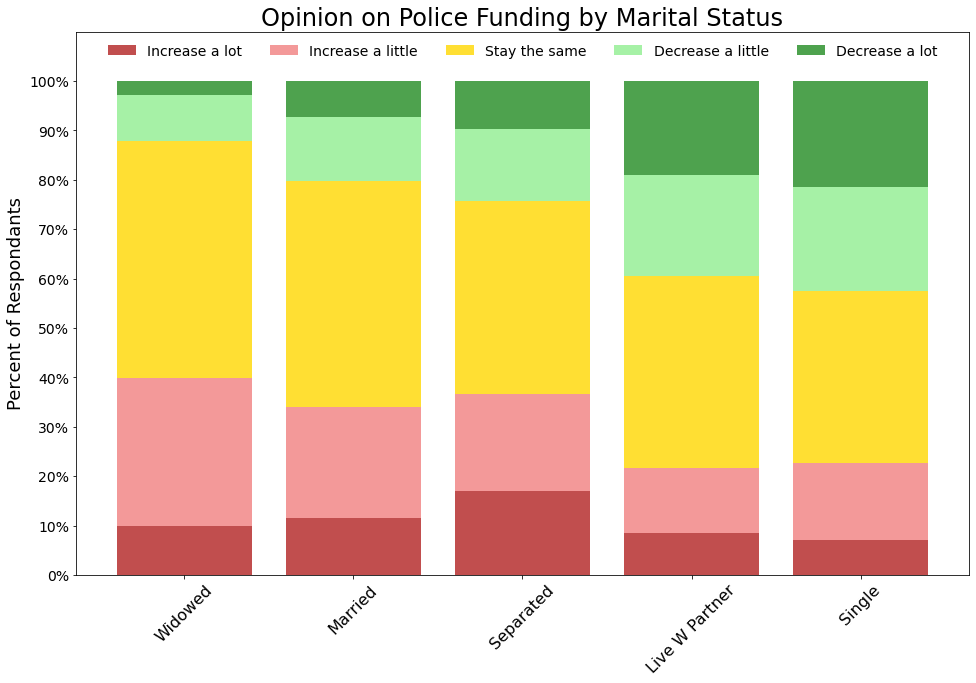

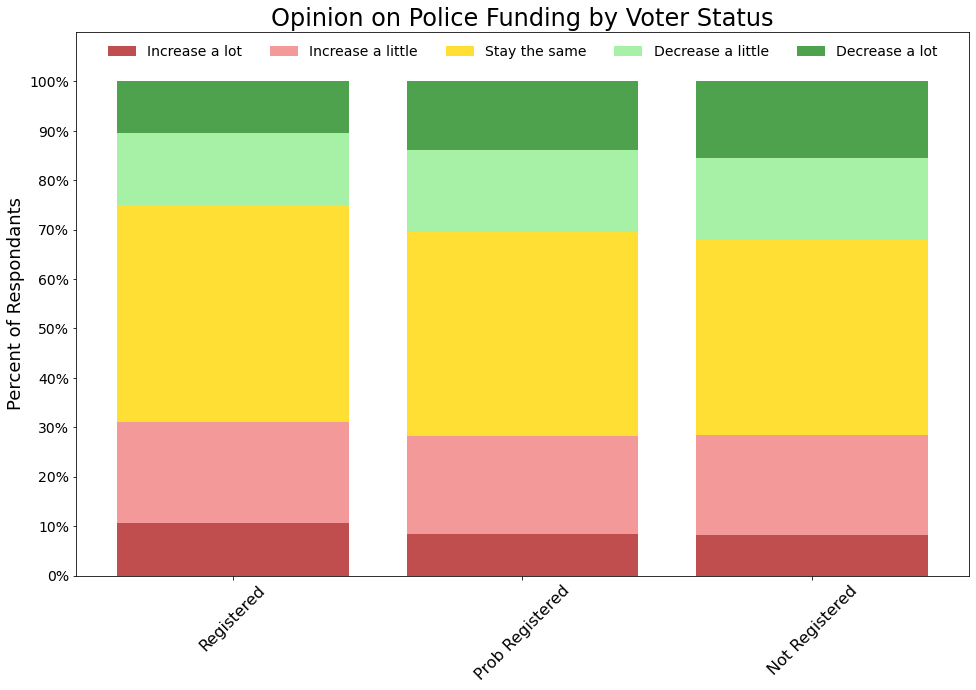

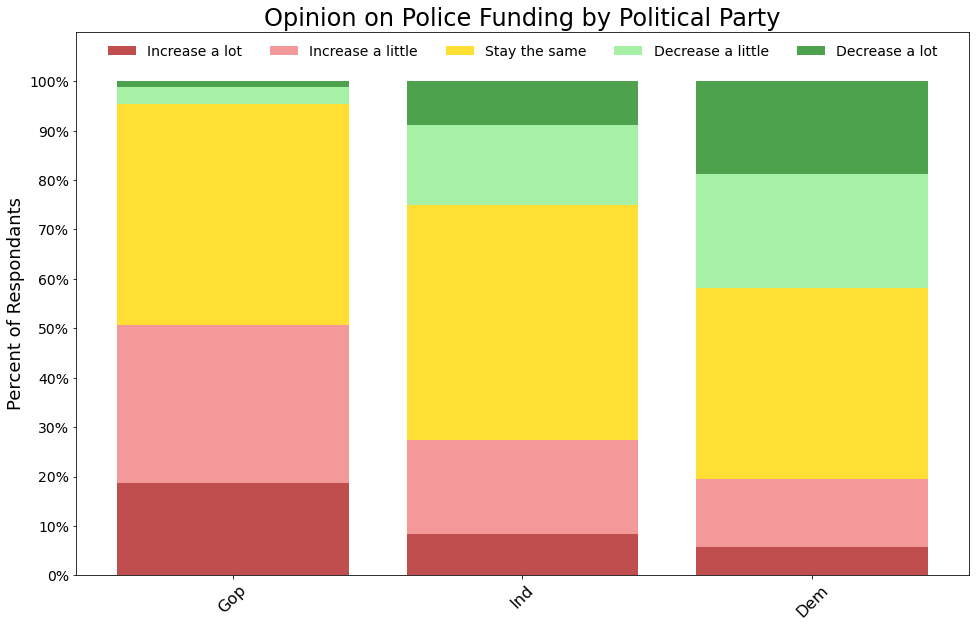

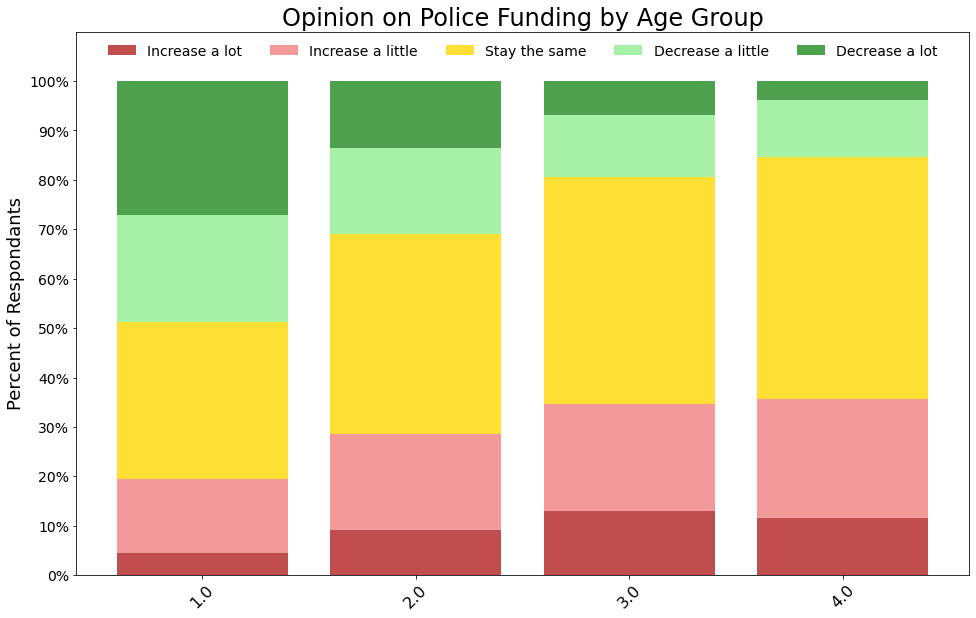

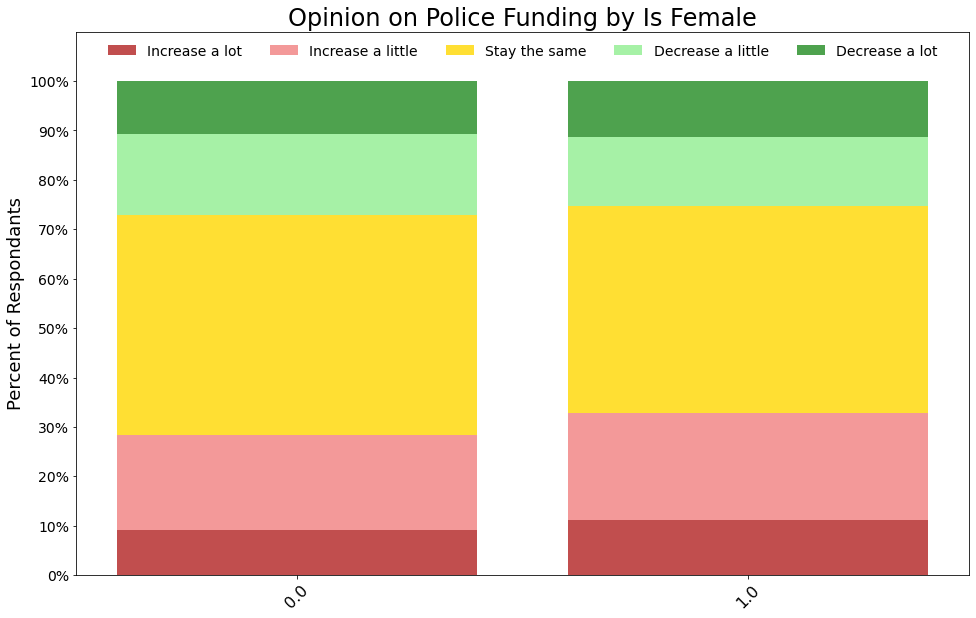

In [13]:
# creating a function to chart opinion data

def grouped_chart(cat):
    # selecting all columns that start with the category value (i.e. 'region' will select 'region_new_england', etc)
    cols = df.columns[df.columns.str.startswith(cat)]
    
    # if there is more than one column in that category, create a df with crosstab counts 
    # for each police funding survey response and each column in the category
    if len(cols) > 1:
        grouped = df.groupby('defund_support').sum()[cols]
        
        # converting those counts to percentages and transposing the df
        for col in cols:
            grouped[col] = grouped[col] / df[col].sum()
        grouped = grouped.T.sort_values(5)
        
        # creating bar labels from the column names
        ticks = [' '.join([word.capitalize() for word in col[len(cat)+1:].split('_')]) for col in list(grouped.index)]
        
        
    # if there is only one column, create a dataframe with counts for each of the unique values in that column    
    else:
        col = cols[0]
        # creating bar labels from the unique values
        ticks = list(df[col].unique())
        
        # creating a df with a row for each police funding survey response (1-5)
        grouped = pd.DataFrame(index = range(1,6))
        
        # adding the count of people with each police funding survey response with each unique value in the column
        for val in ticks:
            grouped[val] = [0,0,0,0,0]
            total = df[df[col] == val].shape[0]
            for i in range(1,6):
                count = df[df[col]==val].groupby('defund_support').count().mean(axis=1)[i]

                grouped.loc[i,val] = count
            
            # converting counts to percentages and transposing the df
            grouped[val] = grouped[val] / total
        grouped = grouped.T.sort_values(5) 
        
    # each police funding survey response (1-5) 
    fields = grouped.columns
    
    # labeling each police funding survey response
    labels = ['Increase a lot', 'Increase a little', 'Stay the same','Decrease a little', 'Decrease a lot']
    
    # setting colors for each police funding survey response
    colors = ['firebrick','lightcoral','gold','lightgreen','forestgreen']    
    

    plt.figure(figsize = (16,10))
    bottom = len(grouped) * [0]

    # creating stacked bars for each value in the category
    for i, field in enumerate(fields):
        plt.bar(grouped.index, grouped[field], bottom = bottom, color = colors[i], alpha = 0.8)
        bottom = bottom + grouped[field]

    # using the name of the category to create a title
    title = ' '.join([word.capitalize() for word in cat.split('_')])

    plt.title('Opinion on Police Funding by '+title,fontsize = 24)
    plt.legend(labels, ncol=len(fields),loc='upper center',frameon=False,fontsize = 14)
    plt.ylabel('Percent of Respondants',fontsize = 18)
    plt.ylim(bottom = 0, top = 1.1)
    plt.yticks(np.arange(0,1.1,0.1), [str(i)+'%' for i in range(0,101,10)],fontsize = 14)
    plt.xticks(grouped.index,labels = ticks, fontsize = 16, rotation = 45)
    plt.show()


# creating charts for the following categories
groups = ['religion','region','race','marital_status', 'voter_status','political_party','age_group','is_female']

for group in groups:
    grouped_chart(group)

### Insights
From these charts, it seems like marginalized folks are more likely to support defunding the police, but sometimes only by a little bit. This includes people of color, people not registered to vote, younger people, and women (although only a little bit for women). As expected, Democrats are much more likely to support defunding the police than Republicans and Independents are somewhere in the middle. 

## Correlations

Now that I have looked at those relationships, I'm going to dummy the columns, create a correlation heatmap, and then move on to modeling.

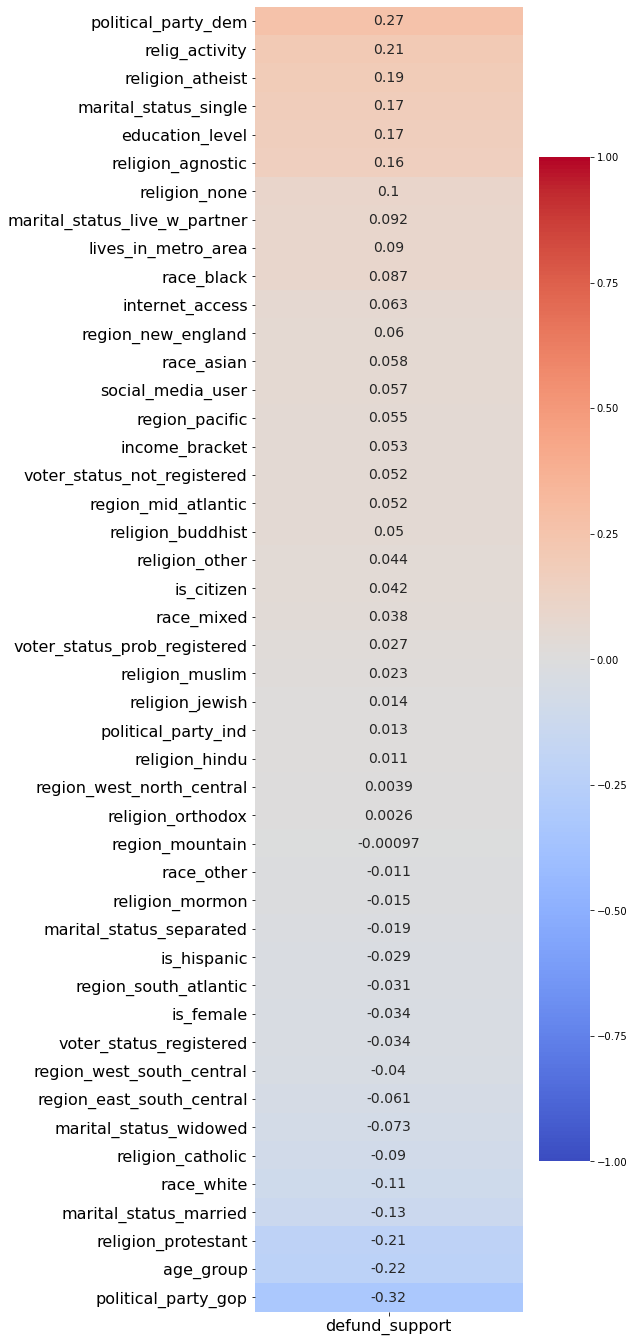

In [14]:
plt.figure(figsize = (6,24))
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
sns.heatmap(df.corr()[['defund_support']].sort_values('defund_support',ascending=False)[1:],
            vmin = -1,
            vmax = 1,
            annot = True,
            annot_kws={"fontsize":14},
            cmap = 'coolwarm',);

### Insights
As with the charts above, there are plenty of relationships here that are intuitive. Older white Republicans are less likely to support defunding the police, while younger Democrats in metro areas are more likely to support. One thing that I find really interesting is that people who identified their religion as agnostic, atheist, or "none" are more likely to support, but those who attend religious activities very frequently (`relig_activity`) are also more likely to support. We'll see how these relationships play out in the modeling notebook!